In [5]:
%load_ext autoreload
%autoreload 2
import dotenv
dotenv.load_dotenv()

True

In [3]:
import os
from matplotlib import pyplot as plt
from experimentator import DataCollector
import numpy as np
from pyconfyg import Confyg

In [ ]:
from mlworkflow import PickledDataset
from experimentator import find
from tqdm.auto import tqdm
from calib3d import Point2D
from deepsport_utilities.court import BALL_DIAMETER
ds = PickledDataset(find("camera_with_ball_visible_views.pickle"))
data = []
for k in tqdm(ds.keys):
    view = ds.query_item(k)
    x = np.linalg.norm(Point2D(view.calib.width/2, view.calib.height/2) - view.calib.project_3D_to_2D(view.ball.center))
    x = x*(calib.K[0,0])/(view.calib.K[0,0]) # project to reference camera
    y = view.calib.compute_length2D(view.ball.center, BALL_DIAMETER)[0]
    data.append((x, y))

In [144]:
data2 = []
refcalib = Calib.load("calib_1936x1458.pickle")
ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))
for k in tqdm(ds.keys):
    for instant in ds.query_item(k):
        ball = instant.ball
        calib = instant.calibs[ball.camera]
        x = np.linalg.norm(Point2D(calib.width/2, calib.height/2) - calib.project_3D_to_2D(ball.center))
        x = x*(refcalib.K[0,0])/(calib.K[0,0]) # project to reference camera
        y = calib.compute_length2D(ball.center, BALL_DIAMETER)[0]
        data2.append((x, y))


instants_ballistic_trajectories_600ms_filtered.pickle found in /home/ucl/elen/gvanzand/DeepSport/datasets/instants_ballistic_trajectories_600ms_filtered.pickle


  0%|          | 0/141 [00:00<?, ?it/s]

[autoreload of deepsport_utilities.ds.instants_dataset.views_transforms failed: Traceback (most recent call last):
  File "/home/ucl/elen/gvanzand/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/ucl/elen/gvanzand/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/opt/sw/arch/easybuild/2020b/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/auto/home/users/g/v/gvanzand

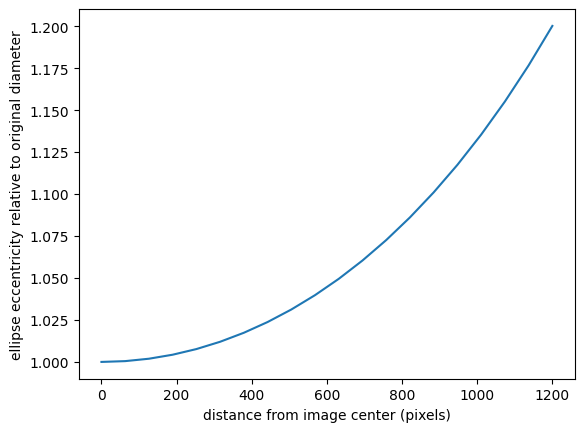

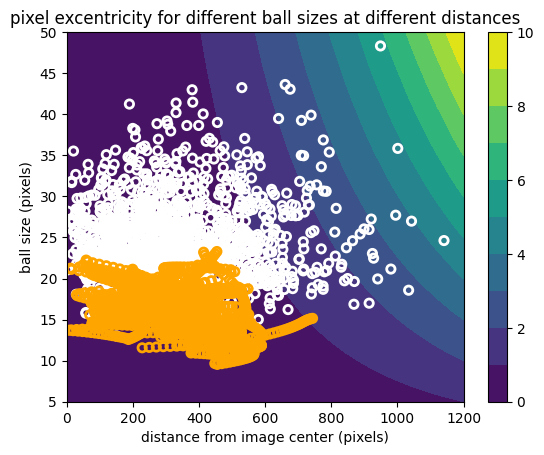

In [149]:
from calib3d import Calib
import matplotlib as mpl

refcalib = Calib.load("calib_1936x1458.pickle")
dist_max = 1200
fovx = np.arctan(dist_max/refcalib.K[0,0])
alpha = np.linspace(0, fovx, 20)
factor = 1/np.cos(alpha)
distance = alpha/fovx*dist_max
plt.plot(distance, factor)
plt.xlabel("distance from image center (pixels)")
plt.ylabel("ellipse eccentricity relative to original diameter")
plt.show()

sizes = np.arange(5, 51)
X, Y = np.meshgrid(distance, sizes)
Z = 1/np.cos(X*fovx/dist_max)*Y-Y
plt.contourf(X, Y, Z, levels=np.arange(11))
plt.colorbar()
plt.ylabel("ball size (pixels)")
plt.xlabel("distance from image center (pixels)")
plt.title("pixel excentricity for different ball sizes at different distances")
xs, ys = zip(*data)
plt.scatter(xs, ys, marker="o", facecolors='none', linewidths=2, edgecolor='white')
xs, ys = zip(*data2)
plt.scatter(xs, ys, marker="o", facecolors='none', linewidths=2, edgecolor='orange')
plt.show()

In [ ]:
from deepsport_utilities.ds.instants_dataset.views_transforms import BallViewRandomCropperTransform
from mlworkflow import FilteredDataset
ds = PickledDataset(find("camera_with_ball_visible_views.pickle"))
ds = FilteredDataset(ds, lambda k: k.timestamp == 1582912356699)
ds = TransformedDataset(ds, [BallViewRandomCropperTransform(scale_max=2, scale_min=2, debug=False, on_ball=True, margin=50, output_shape=(100,100))])
for k in tqdm(ds.keys):
    print(k)
    view = ds.query_item(k)
    draw_ball(view.image, view.calib, view.ball.center, color=(255, 255, 100))
    plt.imshow(view.draw())
    plt.show()
    break

Text(0, 0.5, 'steps')

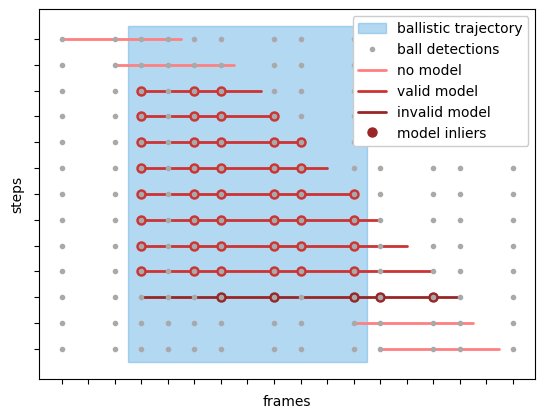

In [154]:
fig = plt.figure()
ax = plt.gca()

detections = [1, 0, 1, 1, -1, 1, 1, 0, -1, 1, 0, 1, 1, 0, 1, 1, 0, 1]
ax.invert_yaxis()
models = [
    (0, 4.5, []),
    (2, 4.5, []),
    (3, 4.5, [3, 5, 6]),
    (3, 5, [3, 5, 6, 8]),
    (3, 6, [3, 5, 6, 8, 9]),
    (3, 7, [3, 5, 6, 8, 9]),
    (3, 8, [3, 5, 6, 8, 9, 11]),
    (3, 9, [3, 5, 6, 8, 9, 11]),
    (3, 10, [3, 5, 6, 8, 9, 11]),
    (3, 11, [3, 5, 6, 8, 9, 11]),
    (3, 12, [6, 8, 11, 12, 14]),
    (11, 4.5, []),
    (12, 4.5, []),
]
ax.fill_between([2.5, 11.5], -.5, len(models)-.5, zorder=.001, alpha=0.5, color=(.4, .7, .9), label="ballistic trajectory")

for f, d in enumerate(detections):
    if d:
        label = 'ball detections'#{1: 'TP', 0: 'FN', -1: 'FP'}[d]
        alpha = {1: 0, -1: 1}[d]
        xs = [f]*len(models)
        ys = range(len(models))
        ax.plot(xs, ys, marker="o", linestyle="", alpha=1, markersize=3, color='darkgray', zorder=1, label=label)

for j, (s, w, inliers) in enumerate(models):
    if l := len(inliers):
        lprev = len(models[j-1][2])
        if lprev == 0:
            color = (.8, .2, .2)
            label = 'valid model'
        elif lprev > l:
            color = (.6, .15, .15)
            label = 'invalid model'
        else:
            color = (.8, .2, .2)
            label = 'valid model'
    else:
        color = (1, .5, .5)
        label = 'no model'
    ax.plot([s, s+w], [j, j], linewidth=2, zorder=.1, color=color, solid_capstyle='round', label=label)
    for i in inliers:
        ax.plot(i, j, marker=".", linestyle="", markersize=13, zorder=.2, color=color, label="model inliers")
            

def legend_without_duplicate_labels(ax):
    from collections import OrderedDict
    handles, labels = ax.get_legend_handles_labels()
    legend = OrderedDict(zip(labels, handles))
    legend.move_to_end('model inliers')
    ax.legend(legend.values(), legend.keys(), framealpha=1)

legend_without_duplicate_labels(ax)
ax.set_xticks(range(len(detections)))
ax.set_xticklabels([""]*len(detections))
ax.set_xlabel("frames")
ax.set_yticks(range(len(models)))
ax.set_yticklabels([""]*len(models))
ax.set_ylabel("steps")

[1.54666667 4.14666667 6.08       7.34666667 7.94666667 7.88
 7.14666667 5.74666667 3.68      ]


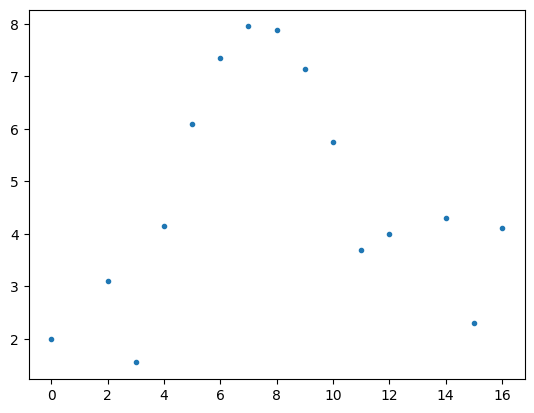

In [176]:
y = -(np.arange(-4,5)-0.4)**2/3+8
detections = np.array([2, 0, 3.1, 1.547, 4.15, 6.08, 7.346, 7.947, 7.88, 7.14, 5.747, 3.68, 4, 0, 4.3, 2.3, 4.1])
print(y)
plt.plot(np.where(detections>0)[0],detections[detections>0], marker=".", linestyle="")

In [ ]:
fig = plt.figure()
ax = plt.gca()

detections = [2, 0, 3.1, 1.547, 0, 6.08, 7.346, 7.947, 7.88, 1.8, 5.747, 3.68, 6, 0, 1, 2.3, 4.1]

ax.invert_yaxis()
models = [
    (0, 4.5, []),
    (2, 4.5, []),
    (3, 4.5, [3, 5, 6]),
    (3, 5, [3, 5, 6, 8]),
    (3, 6, [3, 5, 6, 8, 9]),
    (3, 7, [3, 5, 6, 8, 9]),
    (3, 8, [3, 5, 6, 8, 9, 11]),
    (3, 9, [3, 5, 6, 8, 9, 11]),
    (3, 10, [3, 5, 6, 8, 9, 11]),
    (3, 11, [3, 5, 6, 8, 9, 11]),
    (3, 12, [6, 8, 11, 12, 14]),
    (11, 4.5, []),
    (12, 4.5, []),
]
ax.fill_between([2.5, 11.5], -.5, len(models)-.5, zorder=.001, alpha=0.5, color=(.4, .7, .9), label="ballistic trajectory")

for f, d in enumerate(detections):
    if d:
        label = 'ball detections'#{1: 'TP', 0: 'FN', -1: 'FP'}[d]
        alpha = {1: 0, -1: 1}[d]
        xs = [f]*len(models)
        ys = range(len(models))
        ax.plot(xs, ys, marker="o", linestyle="", alpha=1, markersize=3, color='darkgray', zorder=1, label=label)

for j, (s, w, inliers) in enumerate(models):
    if l := len(inliers):
        lprev = len(models[j-1][2])
        if lprev == 0:
            color = (.8, .2, .2)
            label = 'valid model'
        elif lprev > l:
            color = (.6, .15, .15)
            label = 'invalid model'
        else:
            color = (.8, .2, .2)
            label = 'valid model'
    else:
        color = (1, .5, .5)
        label = 'no model'
    ax.plot([s, s+w], [j, j], linewidth=2, zorder=.1, color=color, solid_capstyle='round', label=label)
    for i in inliers:
        ax.plot(i, j, marker=".", linestyle="", markersize=13, zorder=.2, color=color, label="model inliers")
            

def legend_without_duplicate_labels(ax):
    from collections import OrderedDict
    handles, labels = ax.get_legend_handles_labels()
    legend = OrderedDict(zip(labels, handles))
    legend.move_to_end('model inliers')
    ax.legend(legend.values(), legend.keys(), framealpha=1)

legend_without_duplicate_labels(ax)
ax.set_xticks(range(len(detections)))
ax.set_xticklabels([""]*len(detections))
ax.set_xlabel("frames")
ax.set_yticks(range(len(models)))
ax.set_yticklabels([""]*len(models))
ax.set_ylabel("steps")

In [ ]:
from collections import defaultdict

ds = PickledDataset(find("camera_with_ball_visible_views.pickle"))
d = defaultdict(int)
for k in tqdm(ds.keys):
    d[k.arena_label] += 1
print(d)
print(sum(list(d.values())))

ds = PickledDataset(find("ballseg_dataset_from_ids_and_ballistic_sds.pickle"))
d = defaultdict(int)
for k in tqdm(ds.keys):
    d[k.arena_label] += 1
print(d)
print(sum(list(d.values())))


ballpos_dataset_KS-FR-BOURGEB_ballseg_from_full_ball_detections.pickle_stitchedonly_ballistic.pickle found in /home/ucl/elen/gvanzand/DeepSport/datasets/ballpos_dataset_KS-FR-BOURGEB_ballseg_from_full_ball_detections.pickle_stitchedonly_ballistic.pickle


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

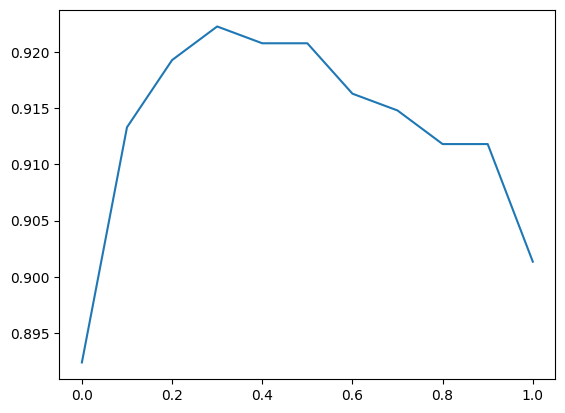

In [197]:
ds = PickledDataset(find("ballpos_dataset_KS-FR-BOURGEB_ballseg_from_full_ball_detections.pickle_stitchedonly_ballistic.pickle"))

a = {}
for tau in np.linspace(0, 1, 11):
    a[tau] = 0
    for key in tqdm(ds.keys, leave=False):
        sample = ds.query_item(key)
        
        detection = max(sample.ball_detections, key=lambda b: b.value)
        if detection.value < tau:
            detection = max(sample.ball_detections, key=lambda b: b.is_ball)
        annotation = sample.ball_annotations[0]
        pos = lambda b: instant.calibs[annotation.camera].project_3D_to_2D(b.center)
        if np.linalg.norm(pos(detection)-pos(annotation)) < 12:
            a[tau] += 1
    a[tau] = a[tau]/len(ds.keys)
plt.plot(list(a.keys()), list(a.values()))

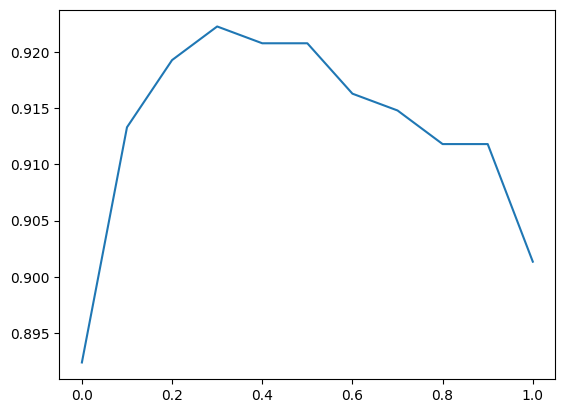

instants_ballistic_trajectories_600ms_filtered.pickle found in /home/ucl/elen/gvanzand/DeepSport/datasets/instants_ballistic_trajectories_600ms_filtered.pickle


0it [00:00, ?it/s]

instants_ballistic_trajectories_600ms_filtered.pickle found in /home/ucl/elen/gvanzand/DeepSport/datasets/instants_ballistic_trajectories_600ms_filtered.pickle


0it [00:00, ?it/s]

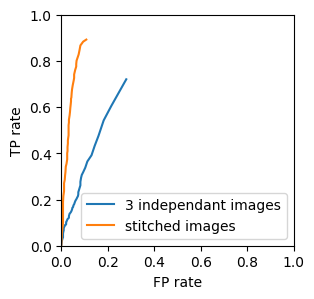

In [196]:
from dataset_utilities.ds.raw_sequences_dataset import RawSequencesDataset, SplittedBallisticTrajectoriesDataset
from tasks.detection import ImportDetectionsTransform
from tqdm.auto import tqdm
from mlworkflow import PickledDataset, TransformedDataset, FilteredDataset
from experimentator import find

ax = plt.figure(figsize=(3,3)).gca()

for filename, label in [("full_ball_detections.pickle", "3 independant images"), ("full_ball_detections.pickle_stitched", "stitched images")]:
    sds = RawSequencesDataset(progress_wrapper=tqdm)
    dataset_folder = sds.dataset_folder
    ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))
    ds = FilteredDataset(ds, lambda k: k.arena_label == "KS-FR-BOURGEB")
    ids = SplittedBallisticTrajectoriesDataset(ds)
    ids = TransformedDataset(ids, [
        ImportDetectionsTransform(
            dataset_folder=dataset_folder,
            filename=filename,
            estimate_pseudo_annotation=False,
            remove_true_positives=False),
    ])
    thresholds = np.linspace(0, 1, 51)
    TPs = np.zeros_like(thresholds)
    FPs = np.zeros_like(thresholds)
    for key in tqdm(ids.keys):
        instant = ids.query_item(key)
        detection = max(instant.detections, key=lambda b: b.value)
        annotation = instant.ball
        pos = lambda b: instant.calibs[annotation.camera].project_3D_to_2D(b.center)
        if np.linalg.norm(pos(detection)-pos(annotation)) < 12:
            TPs += detection.value > thresholds
        else:
            FPs += detection.value > thresholds
    ax.plot(FPs/len(ids.keys), TPs/len(ids.keys), label=label)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
ax.set_xlabel('FP rate')
ax.set_ylabel('TP rate')
plt.legend()

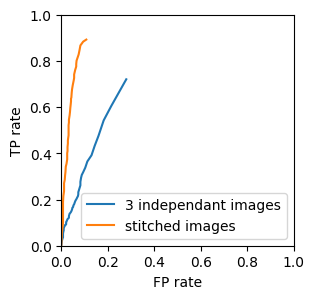

In [ ]:
import os
from matplotlib import pyplot as plt
from experimentator import DataCollector
import numpy as np
from pyconfyg import Confyg

# Does adding a randomly initialized first layer alter the perfomances
subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('backbone', 'VGG'), ('pretrained', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with randomly initialized first layer" if ids[experiment_id]['flayer'] else "without"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Is pre-training on imagenet even necessary
subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('backbone', 'VGG'), ('flayer', False)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "pretrained on imagenet" if ids[experiment_id]['pretrained'] else "random initialization"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does ResNet50 perform better than VGG16?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = ids[experiment_id]['backbone']
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', True), ('with_diff', True)]]):
        ids[experiment_id] = cfg

        
for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', True), ('with_diff', True)]]):
        ids[experiment_id] = cfg

        
for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

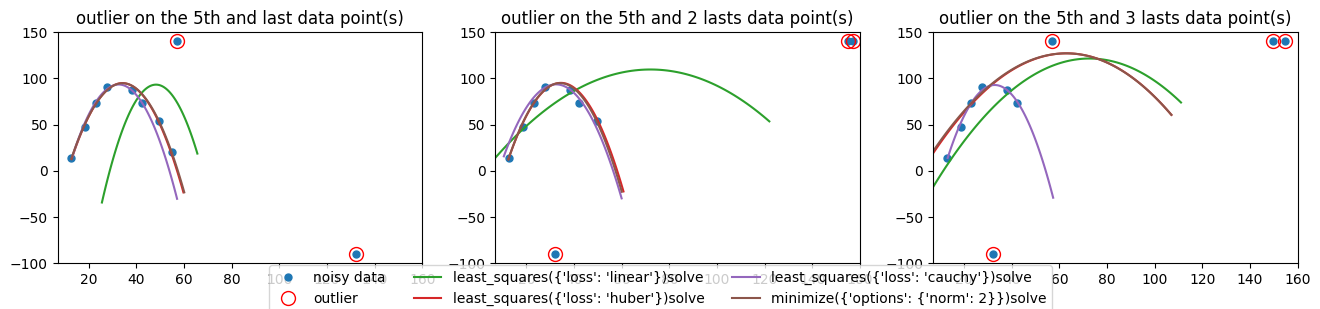

In [244]:
import scipy.optimize
import numpy as np
from matplotlib import pyplot as plt

N = 10
t = np.arange(N)

x0, y0, vx0, vy0 = 10, 10, 5, 40

noise_level = 5

np.random.seed(0)
x_ = x0 + vx0*t + np.random.rand(N)*noise_level
y_ = y0 + vy0*t - 9.81*t**2/2 + np.random.rand(N)*noise_level

indices_list = [
    #({0: (-90, x_[0])}, '1st'),
    #({4: (-90, x_[4])}, "5th"),
    #({-1: (140, x_[-1])}, "last"),
    #({0: (-90, x_[0]), 4: (-90, x_[4])}, '1st and 5th'),
    ({-1: (140, x_[-1]), 4: (-90, x_[4]+100)}, '5th and last'),
    ({-1: (140, x_[-1]+100), -2: (140, x_[-2]+100), 4: (-90, x_[4])}, '5th and 2 lasts'),
    ({-1: (140, x_[-1]), -2: (140, x_[-2]+100), -3: (140, x_[-3]+100), 4: (-90, x_[4])}, '5th and 3 lasts'),
]

fig, axes = plt.subplots(1, len(indices_list), figsize=(16, 3))

for (indices, name), ax in zip(indices_list, axes):
    y = np.array(y_)
    x = np.array(x_)
    for i in indices:
        y[i] = indices[i][0]
        x[i] = indices[i][1]
    
    handles = []
    
    l, = ax.plot(x, y, marker='.', markersize=10, linestyle="", label='noisy data')
    handles.append(l)
    
    l, = ax.plot(x[np.array(list(indices.keys()), dtype=np.int32)], y[np.array(list(indices.keys()), dtype=np.int32)], 'o', markersize=10, markeredgecolor='red', label='outlier', markerfacecolor='None')
    handles.append(l)

    ax.set_title(f"outlier on the {name} data point(s)")
    
    A = np.hstack([np.tile(np.eye(2), (len(t), 1)), np.vstack(np.eye(2)[np.newaxis]*t[...,np.newaxis,np.newaxis])])
    b = np.vstack([np.array([[xi], [yi]]) for xi, yi in zip(x, y)]) - np.vstack(np.eye(2, 1, k=-2)[np.newaxis]*9.81*t[...,np.newaxis,np.newaxis]**2/2)
    
    for igname, initial_guess in {
        #"first": (x[0], y[0], x[1] - x[0], y[1] - y[0]),
        "solve": (np.linalg.inv(A.T@A)@A.T@b).flatten(),
    }.items():

        for optimizer, options in [
            ('least_squares', {'loss': 'linear'}),
            ('least_squares', {'loss': 'huber'}),
            ('least_squares', {'loss': 'cauchy'}),
            #('minimize', {'options': {'norm': -np.inf}}),
            ('minimize', {'options': {'norm': 2}}),
            #('minimize', {'options': {'norm': np.inf}}),
            #('minimize', {'options': {}})
        ]:
            if optimizer == 'minimize':
                def fun(params):
                    x0, y0, vx0, vy0 = params
                    return np.mean(np.sqrt((x0 + vx0*t - x)**2 + (y0 + vy0*t - 9.81*t**2/2 - y)**2))
            else:
                def fun(params):
                    x0, y0, vx0, vy0 = params
                    return np.sqrt((x0 + vx0*t - x)**2 + (y0 + vy0*t - 9.81*t**2/2 - y)**2)

            result = getattr(scipy.optimize, optimizer)(fun, initial_guess, **options)
            label = f"{optimizer}({options})"
            x0, y0, vx0, vy0 = result['x']
            t_ = np.linspace(0, N-1, 100)
            l, = ax.plot(x0 + vx0*t_, y0 + vy0*t_- 9.81*t_**2/2, label=label+igname)
            handles.append(l)
    ax.set_ylim([-100, 150])
    ax.set_xlim([7, 160])
    #ax.set_xticks([])
    #ax.set_yticks([])
fig.legend(handles=handles, loc='lower center', ncols=3, borderaxespad=-0.2)

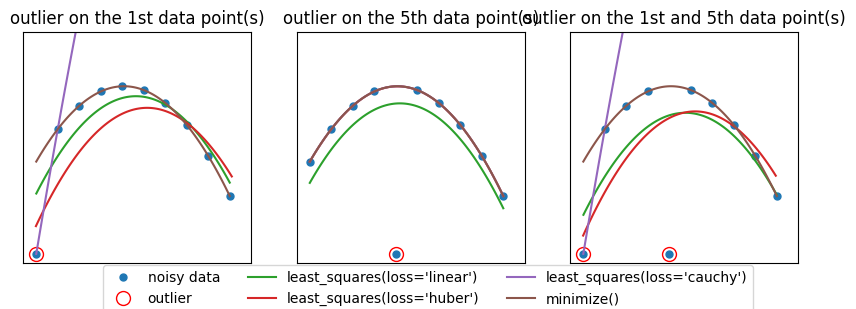

In [ ]:
from mlworkflow import PickledDataset
from matplotlib import pyplot as plt
from deepsport_utilities.court import BALL_DIAMETER
from deepsport_utilities import find
from tqdm.auto import tqdm
import numpy as np

ds = PickledDataset(find("ballsize_dataset.pickle"))
sizes = {}
origins = {}
arenas  = {}
for key in tqdm(ds.keys):
    view = ds.query_item(key)
    arenas.setdefault(key.arena_label, [0])[0] += 1
    sizes.setdefault(view.ball.origin, []).append(view.calib.compute_length2D(BALL_DIAMETER, view.ball.center)[0])
    origins.setdefault(view.ball.origin, [0])[0] += 1
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].hist(list(sizes['annotation']), label='annotations', alpha=.8)
axes[0].hist(list(sizes['interpolation']), label='interpolation', alpha=.8)
axes[0].set_xlabel("ball size [px]")
axes[1].pie([a[0] for a in arenas.values()], labels=list(arenas.keys()))
axes[2].pie([o[0] for o in origins.values()], labels=list(origins.keys()))

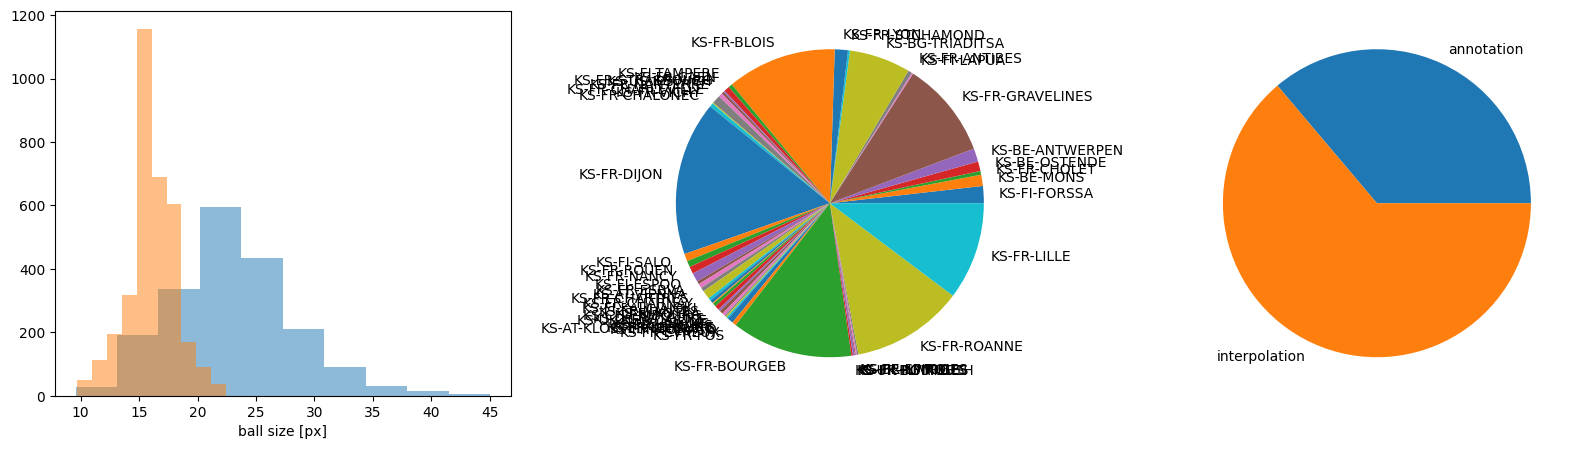

In [ ]:
from experimentator import find
from mlworkflow import PickledDataset
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from deepsport_utilities.utils import color_cycle

ds = PickledDataset(find("ball_states_dataset_with_annotations_and_detections.pickle"))
data = {}
for key in tqdm(ds.keys):
    d = data.setdefault((key.arena_label, key.game_id), {})
    item = ds.query_item(key)
    d.setdefault(item.ball.origin, [0])[0]+=1
    
ax = plt.figure(figsize=(15,4)).gca()
for i, (k, d) in enumerate(data.items()):
    left = 0
    for j, label in enumerate(['ballseg', 'pifball', 'pseudo-annotation', 'annotation', 'interpolation']):
        c = d[label]
        ax.barh(i, c[0], left=left, label=label if i==0 else None, color=color_cycle[j])
        left += c[0]
ax.set_yticks(range(len(data)))
ax.set_yticklabels(list(data.keys()))
ax.legend()

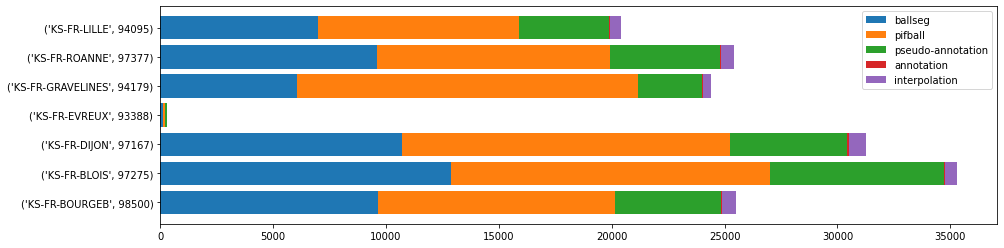

In [ ]:
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
from experimentator import find
from matplotlib import pyplot as plt

ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))

d = {}
for k in tqdm(ds.keys):
    l = d.setdefault(k.arena_label, [])
    l.append(len(ds.query_item(k)))
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

for i, (label, l) in enumerate(d.items()):
    axes[0].hist(l, label=label, range=[20, 50], bins=30)
    axes[1].barh(i, len(l), label=label)
axes[1].set_yticks(list(range(len(d))))
axes[1].set_yticklabels(list(d.keys()))
axes[0].set_title("Duration (number of frames) of annotated ballistic trajectories")
axes[1].set_title("Number of annotated ballistic trajectories")
axes[0].legend()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.4, hspace=0.4)

In [ ]:
print(sum([len(v) for v in d.values()]))
print(sum([sum(v) for v in d.values()]))
3679 - 282

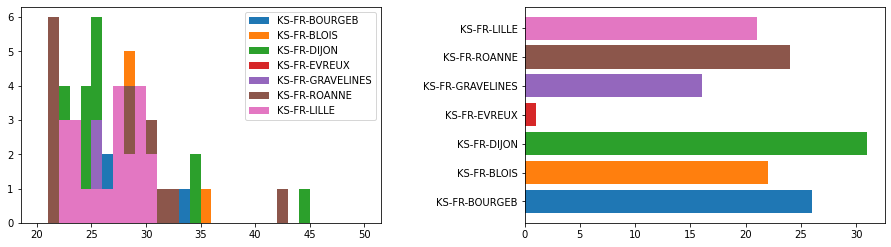

In [ ]:
import boto3
from experimentator.utils import find
from dataset_utilities.ds.raw_sequences_dataset import RawSequencesDataset, compute_size_range
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
import os
from matplotlib import pyplot as plt
from deepsport_utilities.utils import color_cycle
import numpy as np

dummy = boto3.Session()
ds = RawSequencesDataset(session=dummy)
ax = plt.figure().gca()
labels = []
for i, key in enumerate(tqdm(ds.yield_keys())):
    item = ds.query_item(key)
    r = compute_size_range(item.calibs)
    #print(key, r)
    ax.barh(left=r[0], y=i, width=r[1]-r[0], color=color_cycle[0])
    labels.append(key.arena_label)
    
from deepsport_utilities.ds.instants_dataset import InstantsDataset, DownloadFlags
from deepsport_utilities import import_dataset

dataset_folder = "/home/gva/repositories/deepsport/ballistic-raw-sequences"

dataset_config = {
    "dataset_folder": dataset_folder,
    "download_flags": DownloadFlags.WITH_ALL_IMAGES | DownloadFlags.WITH_CALIB_FILE,
}

ids = import_dataset(InstantsDataset, os.path.join(dataset_folder, "raw-basketball-sequences-dataset.json"), **dataset_config)
keys = list(ids.keys.all())
for j, label in enumerate(['STRASBOURG', 'GRAVELINES']):
    key = [k for k in keys if label in k.arena_label][0]
    labels.append(key.arena_label)
    item = ids.query_item(key)
    r = compute_size_range(item.calibs)
    color = np.array([255, 127, 14]) # color_cycle[1]
    ax.barh(left=r[0], y=i+j+1, width=r[1]-r[0], color=color/255)
    ax.barh(left=r[0]/2, y=i+j+1, width=(r[1]-r[0])/2, height=.2, color=color/255/2)
ax.set_xlim([0, 60])
ax.set_yticks(list(range(len(labels))))
ax.set_yticklabels(labels)

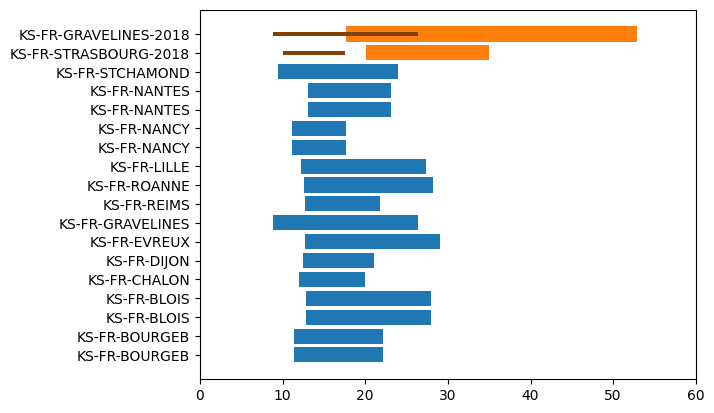

In [ ]:
from dataset_utilities.ds.raw_sequences_dataset import RawSequencesDataset, AddBallStatesTransform, BallState
from deepsport_utilities.utils import color_cycle
import boto3
from tqdm.auto import tqdm
from mlworkflow import TransformedDataset, FilteredDataset
from pprint import pprint
import json
from matplotlib import pyplot as plt

dummy = boto3.Session()
sds = RawSequencesDataset(progress_wrapper=tqdm, session=dummy)
ds = FilteredDataset(sds, lambda k,v: v.ball_states is not None)

states = [BallState(s) for s in range(1,4)]
ax = plt.figure().gca()
labels = []
for i, key in enumerate(ds.yield_keys()):
    labels.append((key.arena_label, key.game_id))
    item = ds.query_item(key)
    filename = os.path.join(sds.dataset_folder, key.arena_label, str(key.game_id), "balls.json")
    data = json.load(open(filename, "r"))
    offset = 0
    for j, s in enumerate(states):
        width = sum([item.ball_states[s][int(k)] if int(k) < len(item.ball_states[s]) else False for k in data.keys()])
        ax.barh(y=i, left=offset, width=width, label=str(s), color=color_cycle[j])
        offset += width
        
ax.legend([str(s) for s in states])
ax.set_yticks(list(range(len(labels))))
ax.set_yticklabels([f"{k[0]} {k[1]}" for k in labels])


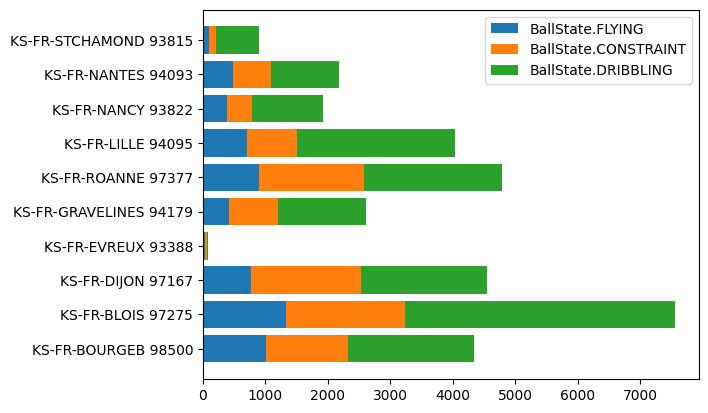

In [ ]:
from deepsport_utilities.utils import color_cycle, find
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
from matplotlib import pyplot as plt
from dataset_utilities.ds.raw_sequences_dataset import BallState

ds = PickledDataset(find("ballstate_dataset.pickle"))
states = [BallState(s) for s in range(1,4)]
ax = plt.figure().gca()

data = {}
for key in tqdm(ds.yield_keys()):
    d = data.setdefault((key.arena_label, key.game_id), {state: 0 for state in states})
    item = ds.query_item(key)
    d[item.ball.state] += 1

for i, d in enumerate(data.values()):
    left = 0
    for j, (state, count) in enumerate(d.items()):
        ax.barh(y=i, left=left, width=count, label=str(state), color=color_cycle[j])
        left += count

ax.legend([str(s) for s in states])
ax.set_yticks(list(range(len(data))))
ax.set_yticklabels(list(data.keys()))


In [ ]:
from mlworkflow import PickledDataset
from experimentator import find

ds = PickledDataset(find("sds_balls_dataset.pickle"))
print(len(ds.keys))
print(set([k.arena_label for k in ds.keys]))

In [ ]:
ds = PickledDataset(find("balltracker-dataset-full.pickle"))
print(len(ds.keys))
print(set([k.arena_label for k in ds.keys]))

In [ ]:
ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))

print(" ".join(set([k.arena_label for k in ds.keys])))

In [ ]:
from experimentator import find
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
from matplotlib import pyplot as plt

ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))
d = {}
e = {}
f = {}
for k in tqdm(ds.keys):
    d.setdefault(k.arena_label, [0])[0] += 1
    e.setdefault(k.arena_label, [0])[0] += len(ds.query_item(k))
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].pie([x[0] for x in d.values()], labels=list(d.keys()))
axes[0].set_title("number of annotated ballistic sequences")
axes[1].pie([x[0] for x in e.values()], labels=list(e.keys()))
axes[1].set_title("number of annotated ballistic instants")
from pprint import pprint
pprint(e)
d = {}
#for name in ['evreux2', 'dijon', 'gravelines', 'lille', 'roanne', 'blois', 'bourgeb']:
#    ds = PickledDataset(find(f"{name}_ballpos_dataset.pickle"))
#    for k in tqdm(ds.keys):
#        d.setdefault(k.arena_label, [0])[0] += len(ds.query_item(k).ball_annotations)
#fig, axes = plt.subplots(1, 2)
#axes[0].pie([a[0] for a in d.values()], labels=list(d.keys()))
#axes[0].set_title("number of annotated ballistic sequences")


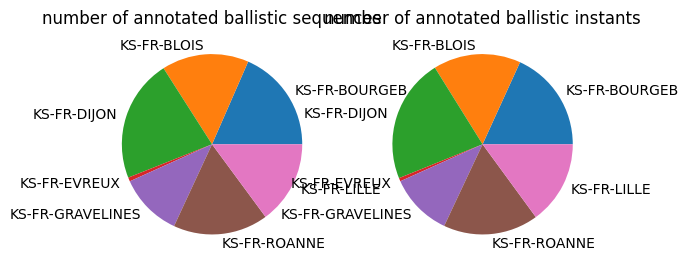

In [ ]:
from experimentator import find
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
from matplotlib import pyplot as plt

d = {}
for name in ['evreux2', 'dijon', 'gravelines', 'lille', 'roanne', 'blois', 'bourgeb']:
    ds = PickledDataset(find(f"{name}_ballpos_dataset.pickle"))
    for k in tqdm(ds.keys):
        d.setdefault(k.arena_label, [0])[0] += len(ds.query_item(k).ball_annotations)
fig, axes = plt.subplots(1, 2)
axes[0].pie([a[0] for a in d.values()], labels=list(d.keys()))
axes[0].set_title("number of annotated ballistic sequences")


In [ ]:
from experimentator import find, CachedPickledDataset
from mlworkflow import PickledDataset
import numpy as np
from tqdm.auto import tqdm
ds = CachedPickledDataset(find("sds_balls_dataset.pickle"))
print(dict(zip(*np.unique([ds.query_item(k).ball.state for k in tqdm(ds.keys)], return_counts=True))))